<a href="https://www.kaggle.com/code/minseo14/arc-task-00d62c1b-build-a-model?scriptVersionId=188903656" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Models in this page are specialized only for the single data, 00d62c1b. 
# Still a necessary step though!

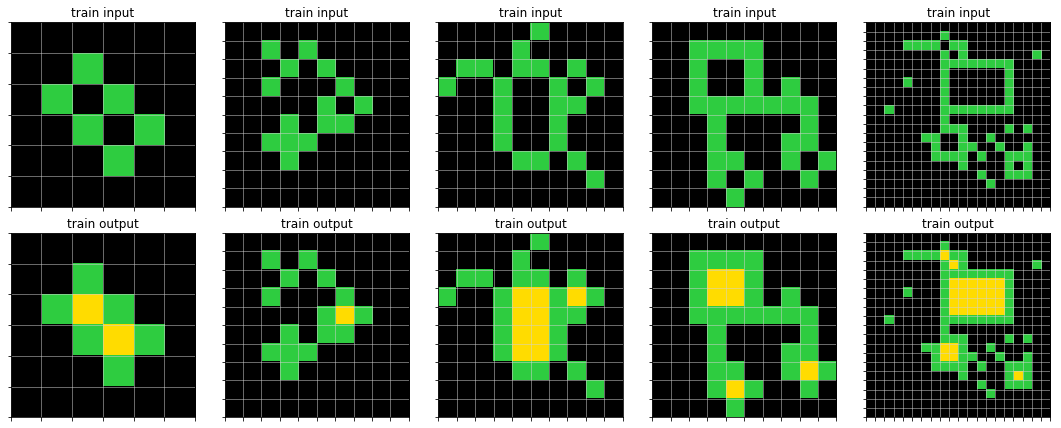

---

# Step 0: Setup

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/arc-prize-2024/arc-agi_training_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_solutions.json
/kaggle/input/arc-prize-2024/arc-agi_evaluation_challenges.json
/kaggle/input/arc-prize-2024/sample_submission.json
/kaggle/input/arc-prize-2024/arc-agi_training_challenges.json
/kaggle/input/arc-prize-2024/arc-agi_test_challenges.json
/kaggle/input/arcsourcecode/data.py
/kaggle/input/arcsourcecode/train.py
/kaggle/input/arcsourcecode/test.py
/kaggle/input/arcsourcecode/constants.py
/kaggle/input/arcsourcecode/classify.py
/kaggle/input/arcsourcecode/2_00d62c1b.png
/kaggle/input/arcsourcecode/utils/analyze.py
/kaggle/input/arcsourcecode/utils/lightning_custom.py
/kaggle/input/arcsourcecode/utils/visualize.py
/kaggle/input/arcsourcecode/configs/train.yaml
/kaggle/input/arcsourcecode/configs/test.yaml
/kaggle/input/arcsourcecode/configs/model/ShapeStableSolver.yaml
/kaggle/input/arcsourcecode/configs/data/train.yaml
/kaggle/input/arcsourcecode/configs/data/test.yaml


In [2]:
!pip install hydra-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 4.7 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=6a23322364ba620b735623d6278eb8d4d5323dc75c4a36ff6c9f6bda7e26a98b
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a127edc45659556564c5730f6d4e300888f4bca2d4c5a88
Successfully built antlr4-python3-runtime


In [3]:
import sys
sys.path.insert(1, '/kaggle/input/arcsourcecode')

In [4]:
from omegaconf import OmegaConf
from train import train
from test import test

In [5]:
base_path = '/kaggle/input/arc-prize-2024/'

# Hyperparameters for Training
config_data = OmegaConf.load("/kaggle/input/arcsourcecode/configs/data/train.yaml")
config_model = OmegaConf.load("/kaggle/input/arcsourcecode/configs/model/ShapeStableSolver.yaml")
config_train = OmegaConf.load("/kaggle/input/arcsourcecode/configs/train/default.yaml")
config_train_default = OmegaConf.load("/kaggle/input/arcsourcecode/configs/train.yaml")

config_train = OmegaConf.merge({'data': config_data, 'model': config_model, 'train': config_train, **config_train_default})

config_train.data.params.base_path = '/kaggle/input/arc-prize-2024/'
config_train.save_path = './output/'

# Hyperparameters for Testing
config_data = OmegaConf.load("/kaggle/input/arcsourcecode/configs/data/test.yaml")
config_model = OmegaConf.load("/kaggle/input/arcsourcecode/configs/model/ShapeStableSolver.yaml")
config_test_default = OmegaConf.load("/kaggle/input/arcsourcecode/configs/test.yaml")

config_test = OmegaConf.merge({'data': config_data, 'model': config_model, **config_test_default})

config_test.data.params.base_path = '/kaggle/input/arc-prize-2024/'

Data size: 1

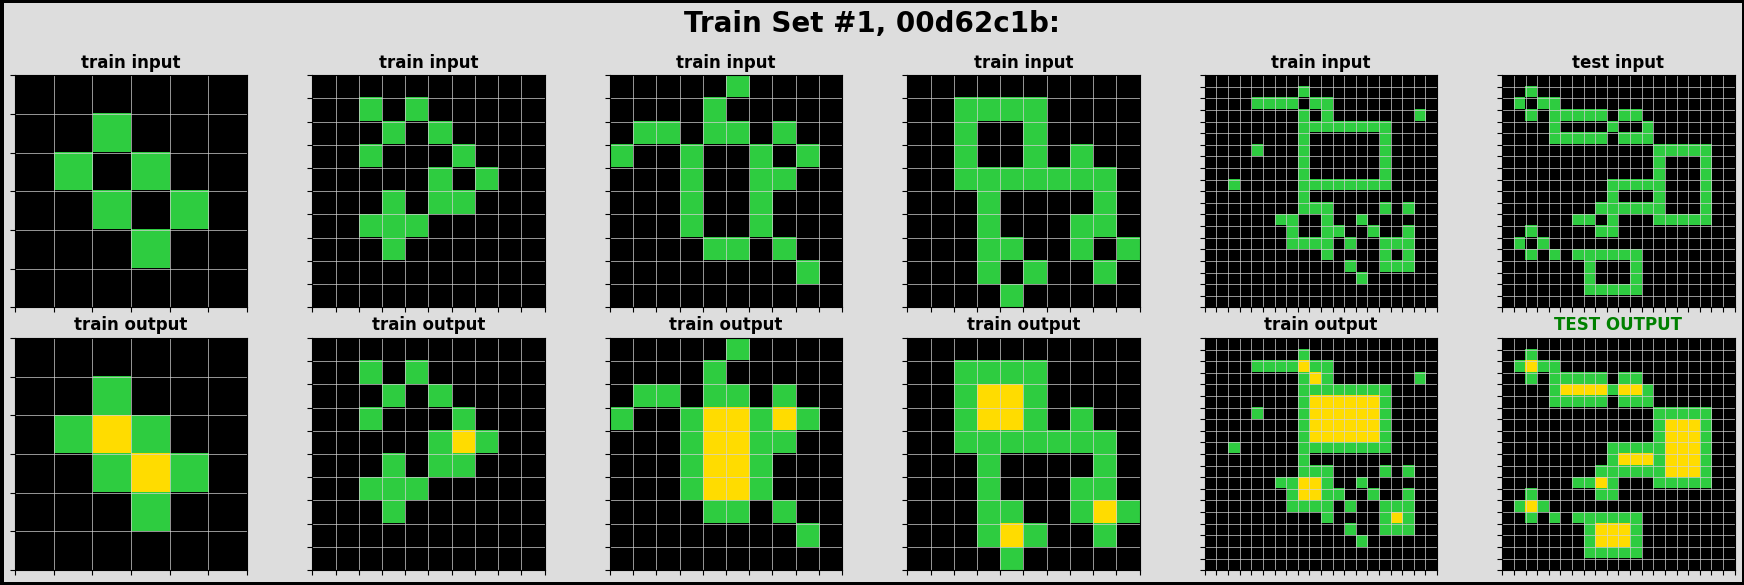

In [6]:
from rich import print

from data import ARCDataset
from constants import get_challenges_solutions_filepath
from classify import ARCDataClassifier
from utils.visualize import plot_task


verbose = True
data_category = 'train'

challenges, solutions = get_challenges_solutions_filepath(data_category, base_path)

# Example usage
filter_funcs = (
    ARCDataClassifier.in_data_codes_f(['00d62c1b']),
#     ARCDataClassifier.is_same_shape_f(True),
#     ARCDataClassifier.is_n_m_colored_in_out_f(2, 3),
#     ARCDataClassifier.is_dominent_color_stable_f(True),
)

dataset_train = ARCDataset(challenges, solutions, train=True, one_hot=False, filter_funcs=filter_funcs)
dataset_test = ARCDataset(challenges, solutions, train=False, one_hot=False, filter_funcs=filter_funcs)
print(f'Data size: {len(dataset_train)}')

# Visualize a task
for index in range(len(dataset_train)):
    plot_task(dataset_train, dataset_test, index, data_category)
    break

# Step 1: Only predict the positions to be substituted

In [7]:
config_train.data.params.ignore_color = True

train(config_train)

data:
  name: ShapeStableSolver
  params:
    base_path: /kaggle/input/arc-prize-2024/
    batch_size: 1
    cold_value: -1
    augment_data: true
    ignore_color: true
model:
  name: ShapeStableSolver
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 128
    - 32
train:
  name: default
  params:
    epoch: 50
    lr: 0.01
defaults:
- data: train
- model: ShapeStableSolver
- train: default
save_path: ./output/

ShapeStableSolverL(
  (model): ShapeStableSolverIgnoreColor(
    (feature_extractor): ConvFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
          (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=128, out_features=32, bias=False)
          (relu_0): ReLU()
          (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (decoder): Conv2dEncoderLayer(
        (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=128, out_features=32, bias=False)
          (relu_0): ReLU()
          (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (out): Linear(in_features=32, out_features=1, bias=False)
        )
      )
      (attn_reduction): ReductiveAttention(
        (attention_weight_layer): AttentionWeight()
        (weight_sum_layer): WeightSum()
      )
    )
  )
  (loss_fn_source): BCEWithLogitsLoss()
)

2024-07-19 05:03:38.366197: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-19 05:03:38.366336: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-19 05:03:38.512439: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:68: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.


┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type                         ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ ShapeStableSolverIgnoreColor │ 98.6 K │ train │
│ 1 │ loss_fn_source │ BCEWithLogitsLoss            │      0 │ train │
└───┴────────────────┴──────────────────────────────┴────────┴───────┘

Trainable params: 98.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 98.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Train loss: 14.865168

Train loss: 4.495076

Train loss: 3.032176

Train loss: 1.229241

Train loss: 0.439519

Train loss: 0.259089

Train loss: 0.225045

Train loss: 0.201646

Train loss: 0.207853

Train loss: 0.170137

Train loss: 0.949363

Train loss: 0.479971

Train loss: 0.126967

Train loss: 0.047751

Train loss: 0.023328

Train loss: 0.011316

Train loss: 0.008433

Train loss: 0.007058

Train loss: 0.006100

Train loss: 0.005365

Train loss: 0.004772

Train loss: 0.004285

Train loss: 0.003876

Train loss: 0.003528

Train loss: 0.003228

Train loss: 0.002967

Train loss: 0.002738

Train loss: 0.002536

Train loss: 0.002356

Train loss: 0.002195

Train loss: 0.002051

Train loss: 0.001921

Train loss: 0.001803

Train loss: 0.001696

Train loss: 0.001598

Train loss: 0.001509

Train loss: 0.001427

Train loss: 0.001351

Train loss: 0.001281

Train loss: 0.001216

Train loss: 0.001156

Train loss: 0.001101

Train loss: 0.001049

Train loss: 0.001000

Train loss: 0.000955

Train loss: 0.000912

Train loss: 0.000873

Train loss: 0.000835

Train loss: 0.000800

Train loss: 0.000767

Seed used 2743621984794819119

Model saved to: ./output//model_ShapeStableSolverIgnoreColor.pth

Task: 00d62c1b, index: 1, correct 0.0%

Task: 00d62c1b, index: 2, correct 0.0%

Task: 00d62c1b, index: 3, correct 0.0%

Task: 00d62c1b, index: 4, correct 0.0%

Task: 00d62c1b, index: 5, correct 0.0%

Task: 00d62c1b, index: 6, correct 0.0%

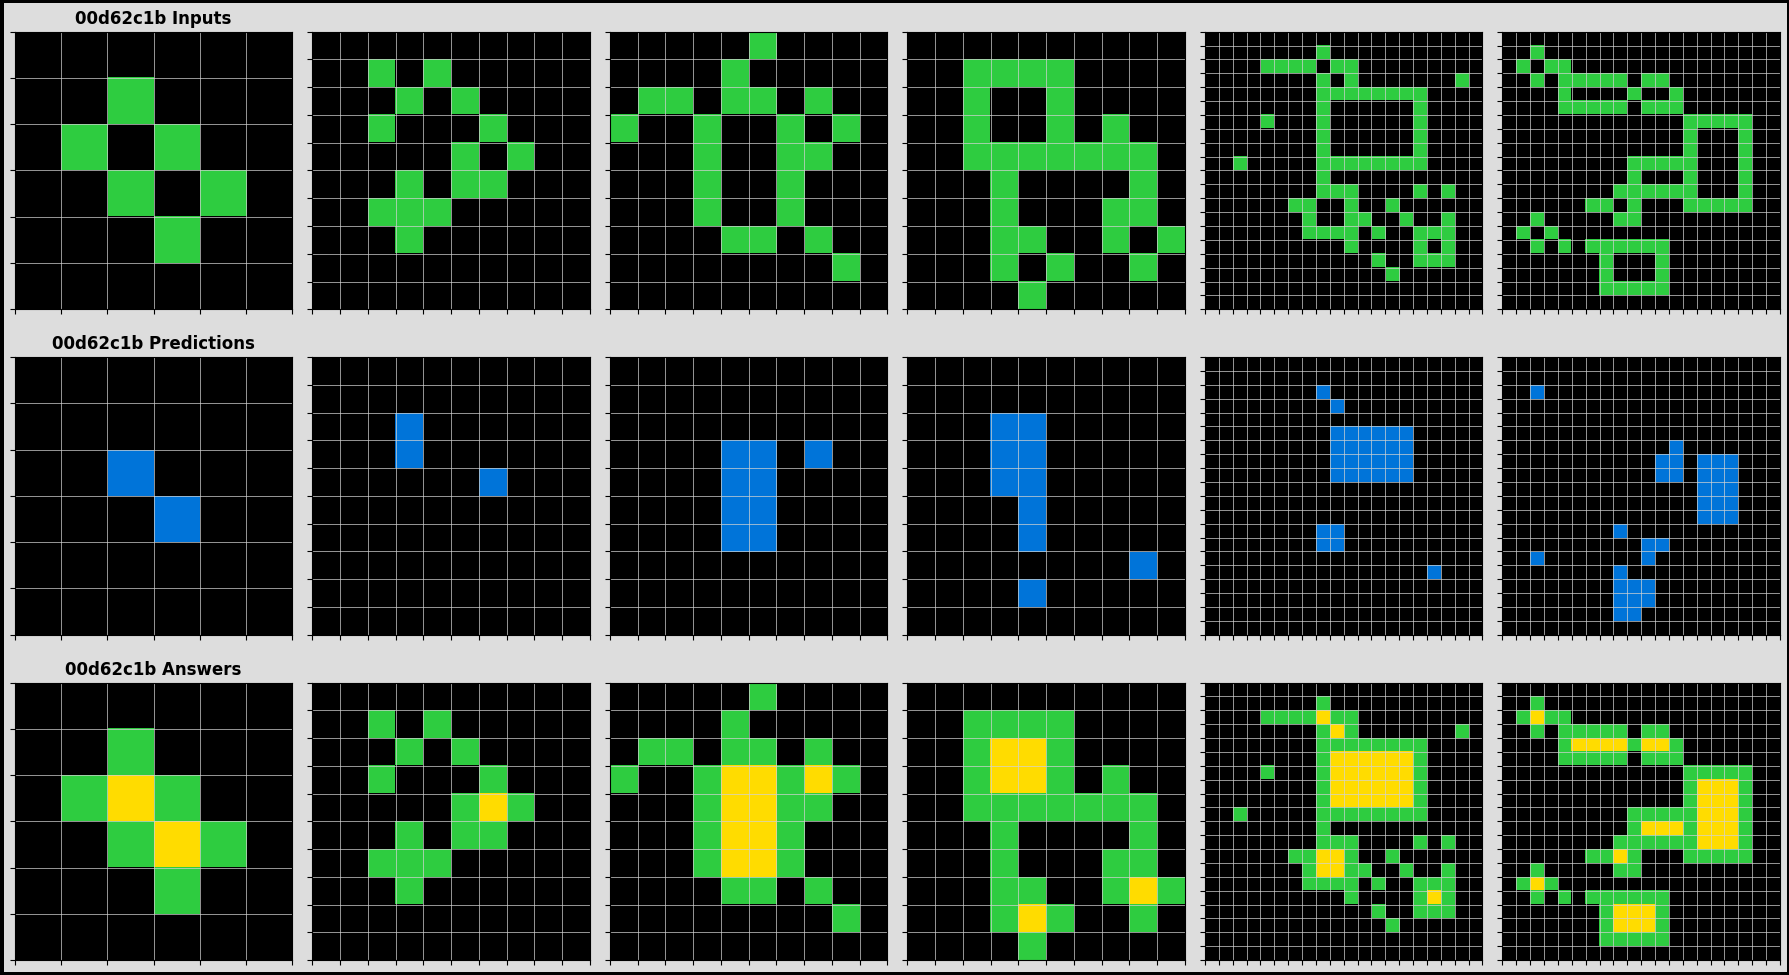

In [8]:
config_test.data.params.ignore_color = True
config_test.model_path = './output/model_ShapeStableSolverIgnoreColor.pth'

test(config_test)

# Step 2: Consider output colors as well

In [9]:
config_train.data.params.ignore_color = False

train(config_train)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


data:
  name: ShapeStableSolver
  params:
    base_path: /kaggle/input/arc-prize-2024/
    batch_size: 1
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: ShapeStableSolver
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 128
    - 32
train:
  name: default
  params:
    epoch: 50
    lr: 0.01
defaults:
- data: train
- model: ShapeStableSolver
- train: default
save_path: ./output/

ShapeStableSolverL(
  (model): ShapeStableSolver(
    (feature_extractor): ConvSameColorFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
          (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=128, out_features=32, bias=False)
          (relu_0): ReLU()
          (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (attn_reduction): ReductiveAttention(
        (attention_weight_layer): AttentionWeight()
        (weight_sum_layer): WeightSum()
      )
      (decoder): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=1, bias=True)
        (3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (linear1): Linear(in_features=10, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=128, out_features=10, bias=True)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (attn_input): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=False)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=1, bias=False)
      (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (loss_fn_source): BCEWithLogitsLoss()
)

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ ShapeStableSolver │ 62.6 K │ train │
│ 1 │ loss_fn_source │ BCEWithLogitsLoss │      0 │ train │
└───┴────────────────┴───────────────────┴────────┴───────┘

Trainable params: 62.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 62.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

Train loss: 17.524834

Train loss: 11.782469

Train loss: 8.855832

Train loss: 6.857990

Train loss: 5.340649

Train loss: 4.351202

Train loss: 3.541446

Train loss: 3.111325

Train loss: 2.718188

Train loss: 2.342854

Train loss: 2.096080

Train loss: 1.740354

Train loss: 1.443949

Train loss: 1.326127

Train loss: 1.318332

Train loss: 1.263012

Train loss: 0.996692

Train loss: 0.969377

Train loss: 0.780041

Train loss: 0.721298

Train loss: 0.825476

Train loss: 0.715227

Train loss: 0.621059

Train loss: 0.554692

Train loss: 0.475494

Train loss: 0.417833

Train loss: 0.388649

Train loss: 0.362830

Train loss: 0.340387

Train loss: 0.319765

Train loss: 0.303617

Train loss: 0.286266

Train loss: 0.273096

Train loss: 0.258530

Train loss: 0.244995

Train loss: 0.233421

Train loss: 0.222247

Train loss: 0.215176

Train loss: 0.203465

Train loss: 0.195853

Train loss: 0.186432

Train loss: 0.179050

Train loss: 0.171396

Train loss: 0.164701

Train loss: 0.158113

Train loss: 0.151967

Train loss: 0.146003

Train loss: 0.140301

Train loss: 0.135230

Train loss: 0.130366

Seed used 12023216947193556241

Model saved to: ./output//model_ShapeStableSolver.pth

Task: 00d62c1b, index: 1, correct 100.0%

Task: 00d62c1b, index: 2, correct 100.0%

Task: 00d62c1b, index: 3, correct 93.0%

Task: 00d62c1b, index: 4, correct 100.0%

Task: 00d62c1b, index: 5, correct 93.5%

Task: 00d62c1b, index: 6, correct 95.5%

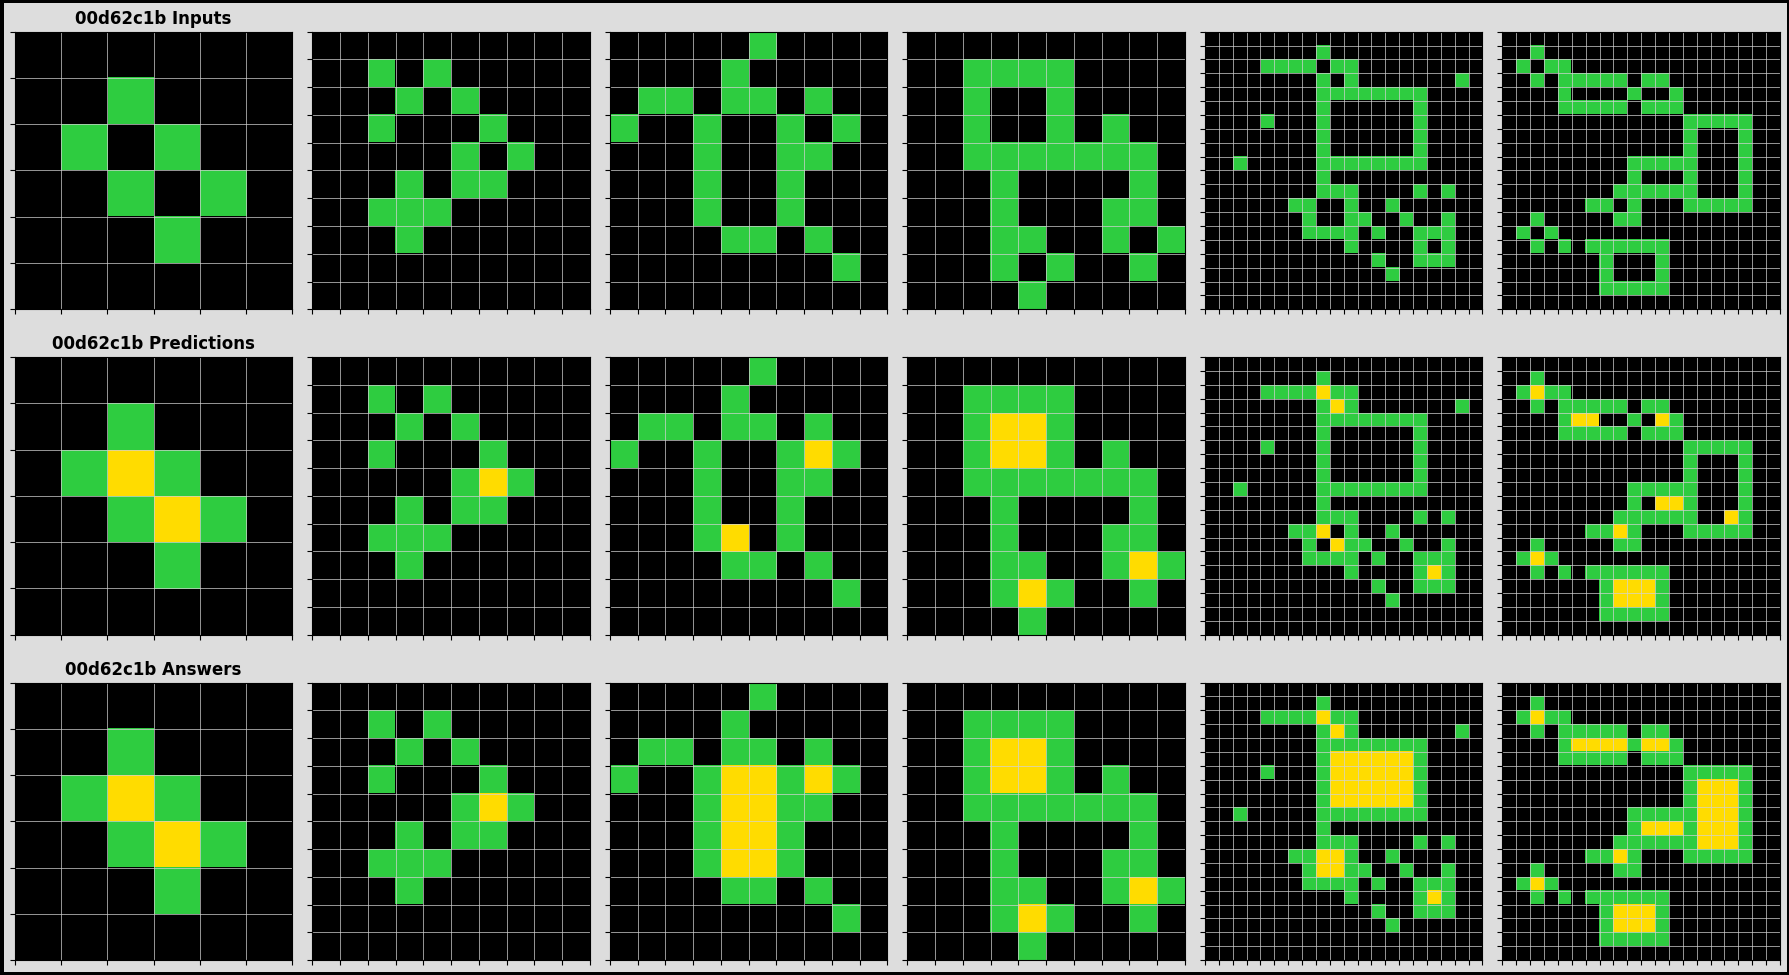

In [10]:
config_test.data.params.ignore_color = False
config_test.model_path = './output/model_ShapeStableSolver.pth'

test(config_test)

# Step 3: Customize the model

## Model which only predicts the positions to be substituted

In [11]:
import torch
from torch import nn

from arc_prize.model_components.convfixedkernel import Conv2dEncoderLayer
from utils.visualize import plot_kernels_and_outputs
from arc_prize.model_components.attention import ReductiveAttention


class ConvFeatureExtractor(nn.Module):
    def __init__(self, pad_value=-1, reduced_channels_encoder=[512, 128, 32], reduced_channels_decoder=[128, 32], recursion=3):
        super().__init__()
        self.recursion = recursion
        self.encoder = Conv2dEncoderLayer(1, reduced_channels_encoder, pad_value=pad_value, fixed_kernel=True)
        self.extender = Conv2dEncoderLayer(reduced_channels_encoder[-1], reduced_channels_decoder, pad_value=pad_value)
        self.decoder = Conv2dEncoderLayer(reduced_channels_decoder[-1], reduced_channels_decoder, pad_value=pad_value, out_one_channel=True)
        self.attn_reduction = ReductiveAttention()
        self.attn_h = nn.Parameter(torch.randn(reduced_channels_decoder[-1]))

    def forward(self, x):
        N, C, H, W = x.shape
        x = x.transpose(1, 0) # [C, N, H, W]

        x_list = []
        for i, x_c in enumerate(x):
            if not torch.any(x_c == 1):
                x_c = x_c.unsqueeze(0) + 1 # .fill_(1) # default value is 0
                x_list.append(x_c)
                continue

            x_c = x_c.view(N, 1, H, W)
            x_c = self.encoder(x_c) # [N, V, H, W]
            x_c_seqs = []
            for _ in range(self.recursion): ### Hyperparameter
                x_c = self.extender(x_c) # [N, V, H, W]
                x_c_seqs.append(x_c.unsqueeze(0))
            x_c_seqs = torch.cat(x_c_seqs) # [S, N, V, H, W]

            S, N, V, H, W = x_c_seqs.shape
            x_c_seqs = x_c_seqs.permute(1, 3, 4, 0, 2).view(N*H*W, S, V)
            x_c = self.attn_reduction(x_c_seqs, self.attn_h.repeat(N*H*W, 1)).view(N, H, W, V).permute(0, 3, 1, 2)
            x_c = self.decoder(x_c).view(N, H, W) # [1, N, H, W]
            x_list.append(x_c.unsqueeze(0))

        x = torch.cat(x_list) 

        return x.transpose(1, 0) # [N, C, H, W]
        
    def to(self, *args, **kwargs):
        self.encoder = self.encoder.to(*args, **kwargs)
        return super().to(*args, **kwargs)


class ShapeStableSolverIgnoreColor(nn.Module):
    def __init__(self, pad_value=-1, reduced_channels_encoder=[512, 128, 32], reduced_channels_decoder=[128, 32], n_classes=10, hidden_size=64):
        super().__init__()
        self.feature_extractor = ConvFeatureExtractor(pad_value, reduced_channels_encoder, reduced_channels_decoder)

    def forward(self, x):
        N, C, H, W = x.shape

        x = self.feature_extractor(x) # [N, C, H, W]
        y_source = x[:, 1:].sum(dim=1).view(N, H, W)

        return y_source

    def to(self, *args, **kwargs):
        self.feature_extractor = self.feature_extractor.to(*args, **kwargs)
        return super().to(*args, **kwargs)


In [12]:
model_class = ShapeStableSolverIgnoreColor
config_train.data.params.ignore_color = True
train(config_train, model_class) # Apply custom model

data:
  name: ShapeStableSolver
  params:
    base_path: /kaggle/input/arc-prize-2024/
    batch_size: 1
    cold_value: -1
    augment_data: true
    ignore_color: true
model:
  name: ShapeStableSolver
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 128
    - 32
train:
  name: default
  params:
    epoch: 50
    lr: 0.01
defaults:
- data: train
- model: ShapeStableSolver
- train: default
save_path: ./output/

ShapeStableSolverL(
  (model): ShapeStableSolverIgnoreColor(
    (feature_extractor): ConvFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
          (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=128, out_features=32, bias=False)
          (relu_0): ReLU()
          (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (decoder): Conv2dEncoderLayer(
        (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=128, out_features=32, bias=False)
          (relu_0): ReLU()
          (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (out): Linear(in_features=32, out_features=1, bias=False)
        )
      )
      (attn_reduction): ReductiveAttention(
        (attention_weight_layer): AttentionWeight()
        (weight_sum_layer): WeightSum()
      )
    )
  )
  (loss_fn_source): BCEWithLogitsLoss()
)

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type                         ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ ShapeStableSolverIgnoreColor │ 98.6 K │ train │
│ 1 │ loss_fn_source │ BCEWithLogitsLoss            │      0 │ train │
└───┴────────────────┴──────────────────────────────┴────────┴───────┘

Trainable params: 98.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 98.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

Train loss: 15.737508

Train loss: 5.325168

Train loss: 3.521874

Train loss: 2.048545

Train loss: 0.648182

Train loss: 0.452321

Train loss: 0.368991

Train loss: 0.233451

Train loss: 0.122828

Train loss: 0.086521

Train loss: 0.059543

Train loss: 0.059618

Train loss: 0.016243

Train loss: 0.009891

Train loss: 0.007940

Train loss: 0.006701

Train loss: 0.005795

Train loss: 0.005094

Train loss: 0.004531

Train loss: 0.004067

Train loss: 0.003678

Train loss: 0.003346

Train loss: 0.003062

Train loss: 0.002814

Train loss: 0.002597

Train loss: 0.002406

Train loss: 0.002235

Train loss: 0.002083

Train loss: 0.001946

Train loss: 0.001823

Train loss: 0.001711

Train loss: 0.001609

Train loss: 0.001516

Train loss: 0.001431

Train loss: 0.001353

Train loss: 0.001282

Train loss: 0.001215

Train loss: 0.001154

Train loss: 0.001098

Train loss: 0.001045

Train loss: 0.000995

Train loss: 0.000949

Train loss: 0.000906

Train loss: 0.000866

Train loss: 0.000828

Train loss: 0.000793

Train loss: 0.000760

Train loss: 0.000729

Train loss: 0.000699

Train loss: 0.000671

Seed used 1519197150396591930

Model saved to: ./output//model_ShapeStableSolverIgnoreColor.pth

## Model which considers output colors as well

In [13]:
import torch
from torch import nn

from arc_prize.model_components.convfixedkernel import Conv2dEncoderLayer
from utils.visualize import plot_kernels_and_outputs
from arc_prize.model_components.attention import ReductiveAttention


class ConvSameColorFeatureExtractor(nn.Module):
    def __init__(self, pad_value=-1, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[512, 32], out_dim=4):
        super().__init__()
        self.V = reduced_channels_decoder[-1]
        self.out_dim = out_dim
        self.encoder = Conv2dEncoderLayer(1, reduced_channels_encoder, pad_value=pad_value, fixed_kernel=True)
        self.extender = Conv2dEncoderLayer(reduced_channels_encoder[-1], reduced_channels_decoder, pad_value=pad_value)
        self.attn_reduction = ReductiveAttention()
        self.attn_h = nn.Parameter(torch.randn(self.V))

        self.decoder = nn.Sequential(
            nn.Linear(self.V, 32, bias=True),
            nn.ReLU(),
            nn.Linear(32, out_dim, bias=True),
            nn.BatchNorm1d(out_dim),
        )

    def forward(self, x):
        N, C, H, W = x.shape
        x = x.transpose(1, 0) # [C, N, H, W]

        x_list = []
        for i, x_c in enumerate(x):
            if not torch.any(x_c == 1):
                x_c = (x_c.view(1, N, 1, H, W) + 1).repeat(1, 1,  self.out_dim, 1, 1) # .fill_(1) # default value is 0
                x_list.append(x_c)
                continue

            x_c = x_c.view(N, 1, H, W)
            x_c = self.encoder(x_c) # [N, V, H, W]
            x_c_seqs = []
            for _ in range(3): ### Hyperparameter
                x_c = self.extender(x_c) # [N, V, H, W]
                x_c_seqs.append(x_c.unsqueeze(0))
            x_c_seqs = torch.cat(x_c_seqs) # [S, N, V, H, W]

            S, N, V, H, W = x_c_seqs.shape
            x_c_seqs = x_c_seqs.permute(1, 3, 4, 0, 2).view(N*H*W, S, V)
            x_c = self.attn_reduction(x_c_seqs, self.attn_h.repeat(N*H*W, 1)).view(N, H, W, V).permute(0, 3, 1, 2)

            x_c = self.decoder(x_c.permute(0, 2, 3, 1).reshape(N*H*W, V)).view(N, H, W, -1).permute(0, 3, 1, 2)
            x_list.append(x_c.unsqueeze(0)) # [1, N, V, H, W]

        x = torch.cat(x_list) # [C, N, V, H, W]

        return x
        
    def to(self, *args, **kwargs):
        self.encoder = self.encoder.to(*args, **kwargs)
        return super().to(*args, **kwargs)


class ShapeStableSolver(nn.Module):
    def __init__(self, pad_value=-1, reduced_channels_encoder=[512, 32], reduced_channels_decoder=[128, 32], hidden_size=1, num_classes=10, feature_dim=1, color_dim=1):
        super().__init__()
        self.feature_extractor = ConvSameColorFeatureExtractor(pad_value, reduced_channels_encoder, reduced_channels_decoder, out_dim=feature_dim)

        self.encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=num_classes, nhead=1, dim_feedforward=128, batch_first=True, bias=True),
            num_layers=1,
        )

        self.attn_input = nn.TransformerDecoder(
            nn.TransformerDecoderLayer(d_model=num_classes, nhead=1, dim_feedforward=1, batch_first=True, bias=False),
            num_layers=1,
        )

        self.decoder = nn.Sequential(
            nn.Linear(color_dim, 1, bias=False),
            nn.BatchNorm1d(1),
        )

        # self.color_vector = nn.Parameter(torch.randn(num_classes, feature_dim)) # dim-1 because the first channel is the input

    def forward(self, x):
        N, C, H, W = x.shape
        y = self.feature_extractor(x) # [C, N, V, H, W]
        y = y.permute(1, 3, 4, 0, 2).reshape(N*H*W, C, -1)

        V = y.shape[2]
        y = y.transpose(2, 1) # [N*H*W, V, C]
        y = self.encoder(y)

        x = x.permute(0, 2, 3, 1).reshape(N*H*W, 1, C).repeat(1, V, 1) # [N*H*W, V, C]
        y = self.attn_input(y, x)
        y = y.transpose(2, 1) # [N*H*W, C, V]

        y = y.reshape(N*H*W*C, V)
        y = self.decoder(y) # [N*H*W*C, 1]
        y = y.view(N, H, W, C).permute(0, 3, 1, 2) # [N, C, H, W]

        return y

    def to(self, *args, **kwargs):
        self.feature_extractor = self.feature_extractor.to(*args, **kwargs)
        return super().to(*args, **kwargs)


In [14]:
model_class = ShapeStableSolver
config_train.data.params.ignore_color = False
train(config_train, model_class) # Apply custom model

data:
  name: ShapeStableSolver
  params:
    base_path: /kaggle/input/arc-prize-2024/
    batch_size: 1
    cold_value: -1
    augment_data: true
    ignore_color: false
model:
  name: ShapeStableSolver
  params:
    reduced_channels_encoder:
    - 512
    - 32
    reduced_channels_decoder:
    - 128
    - 32
train:
  name: default
  params:
    epoch: 50
    lr: 0.01
defaults:
- data: train
- model: ShapeStableSolver
- train: default
save_path: ./output/

ShapeStableSolverL(
  (model): ShapeStableSolver(
    (feature_extractor): ConvSameColorFeatureExtractor(
      (encoder): Conv2dEncoderLayer(
        (conv): Conv2dFixedKernel(1, 512, kernel_size=(3, 3), stride=(1, 1))
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=512, out_features=32, bias=False)
          (relu_0): ReLU()
          (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (extender): Conv2dEncoderLayer(
        (conv): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), bias=False)
        (activation): ReLU()
        (linear_layers): Sequential(
          (linear_0): Linear(in_features=128, out_features=32, bias=False)
          (relu_0): ReLU()
          (norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (attn_reduction): ReductiveAttention(
        (attention_weight_layer): AttentionWeight()
        (weight_sum_layer): WeightSum()
      )
      (decoder): Sequential(
        (0): Linear(in_features=32, out_features=32, bias=True)
        (1): ReLU()
        (2): Linear(in_features=32, out_features=1, bias=True)
        (3): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=True)
          )
          (linear1): Linear(in_features=10, out_features=128, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=128, out_features=10, bias=True)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (attn_input): TransformerDecoder(
      (layers): ModuleList(
        (0): TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (multihead_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=10, out_features=10, bias=False)
          )
          (linear1): Linear(in_features=10, out_features=1, bias=False)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1, out_features=10, bias=False)
          (norm1): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (norm3): LayerNorm((10,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
          (dropout3): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=1, bias=False)
      (1): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (loss_fn_source): BCEWithLogitsLoss()
)

┏━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name           ┃ Type              ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model          │ ShapeStableSolver │ 62.6 K │ train │
│ 1 │ loss_fn_source │ BCEWithLogitsLoss │      0 │ train │
└───┴────────────────┴───────────────────┴────────┴───────┘

Trainable params: 62.6 K                                                                                           
Non-trainable params: 0                                                                                            
Total params: 62.6 K                                                                                               
Total estimated model params size (MB): 0

Output()

Train loss: 17.871597

Train loss: 12.014820

Train loss: 9.055574

Train loss: 6.929099

Train loss: 5.430265

Train loss: 4.420617

Train loss: 3.749835

Train loss: 3.042886

Train loss: 2.892470

Train loss: 2.611289

Train loss: 2.057821

Train loss: 1.869876

Train loss: 1.723172

Train loss: 1.487619

Train loss: 1.261527

Train loss: 1.078300

Train loss: 0.947309

Train loss: 0.953451

Train loss: 0.820891

Train loss: 0.768918

Train loss: 0.744517

Train loss: 0.652969

Train loss: 0.595279

Train loss: 0.595904

Train loss: 0.522289

Train loss: 0.473960

Train loss: 0.405675

Train loss: 0.408622

Train loss: 0.454364

Train loss: 0.409412

Train loss: 0.383822

Train loss: 0.332256

Train loss: 0.322007

Train loss: 0.306458

Train loss: 0.277161

Train loss: 0.368791

Train loss: 0.327611

Train loss: 0.375970

Train loss: 0.350726

Train loss: 0.277823

Train loss: 0.263689

Train loss: 0.200369

Train loss: 0.182261

Train loss: 0.167781

Train loss: 0.159537

Train loss: 0.152769

Train loss: 0.147087

Train loss: 0.139982

Train loss: 0.135604

Train loss: 0.130255

Seed used 15217836827559245695

Model saved to: ./output//model_ShapeStableSolver.pth